# Combining restaurant health inspection and Foursquare data to help consumers and restaurants

This jupyter notebook presents some preliminary analysis of restaurant health inspection data for NYC. This data, collected by the Department of Health and Mental Hygiene (DOHMH) is available from https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j. I completed this work as part of my capstone project for IBM's Data Science Professional Certificate on Coursera. One major goal of this notebook was to link the health inspection data with Foursquare data on location and user rating, as we needed to make use of the Foursquare API for the course. My solution for this is admittedly very quick-and-dirty. This is my first time working in Python, and another major goal of this work for me was simply to get more comfortable working with common Python libraries (pandas, numpy, scikit-learn). 

I've tried to look at the data from the perspective of the consumers (Foursquare users), the restaurants, and the DOHMH, creating products that could benefit each potential stakeholder. 


In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
##import modules
from statistics import mode
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


In [3]:
## Hidden cell below imports my foursquare API credentials to CLIENT_ID and CLIENT_SECRET, VERSION to '20181001'
## These are all required for making foursquare API calls

In [4]:
# The code was removed by Watson Studio for sharing.

# Data Cleaning and Preparation: DOHMH Restaurant Inspections

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
## Read from Project Data - this is a copy of the DOHMH (Department of Health and Mental Hygiene) Restaurant Inspection Report downloaded September 30th, 2018
## https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

In [7]:
## rename inspection dataframe to "health". Standardize column names. Peek at the data. 
health=df_data_1
health=health.reset_index()
health.columns = [c.replace(' ', '_') for c in health.columns]
health.columns = map(str.lower, health.columns)
health.head()

,index,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type
0,0,40384188,LA MELA RESTAURANT,MANHATTAN,167,MULBERRY STREET,10013.0,2124319493,Italian,03/09/2017,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,5.0,A,03/09/2017,09/30/2018,Cycle Inspection / Initial Inspection
1,1,41575026,BRGR,MANHATTAN,1026,3 AVENUE,10065.0,2125880080,American,08/03/2015,Violations were cited in the following area(s).,09C,Food contact surface not properly maintained.,Not Critical,7.0,A,08/03/2015,09/30/2018,Cycle Inspection / Initial Inspection
2,2,50018539,Z BAR,QUEENS,2612,HOYT AVE S,11102.0,3476124715,American,02/09/2016,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,24.0,NaN,NaN,09/30/2018,Cycle Inspection / Initial Inspection
3,3,40545741,BOB'S STEAK & CHOP HOUSE,MANHATTAN,21,EAST 52 STREET,10022.0,2127545031,American,10/06/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,47.0,NaN,NaN,09/30/2018,Cycle Inspection / Initial Inspection
4,4,41705634,EXPRESS BROOK LUNCH RESTAURANT,BRONX,502,EAST 138 STREET,10454.0,7185855880,Spanish,06/15/2017,Establishment Closed by DOHMH. Violations wer...,06F,Wiping cloths soiled or not stored in sanitizi...,Critical,51.0,NaN,NaN,09/30/2018,Cycle Inspection / Re-inspection


In [8]:
## Each restaurant has a unique ID assigned by the DOHMH (camis)
## How many restaurants are there?
health['camis'].nunique()



26768

In [9]:
## I can't use these to match to the Foursquare database. I'll have to search for each restaurant usings its name and address.
## I'll first make a new column combining name and address
health["name_address"] = health['dba'] + " " + health['building'] + " " + health['street']
print(health["name_address"].head())
health["name_address"].nunique()

0               LA MELA RESTAURANT 167 MULBERRY STREET
1                                   BRGR 1026 3 AVENUE
2                                Z BAR 2612 HOYT AVE S
3         BOB'S STEAK & CHOP HOUSE 21 EAST   52 STREET
4    EXPRESS BROOK LUNCH RESTAURANT 502 EAST  138 S...
Name: name_address, dtype: object


26154

In [10]:
## So there are fewer unique name/address combinations than there are restaurant IDs from the DOHMH
## If name, building number, or street are missing, name_address will equal NA in the string concatenation above. 
## How many of these are missing name/building/street?
print("Number of missing streets: ", health['street'].isna().sum())
print("Number of missing buildings: ", health['building'].isna().sum())
print("Number of missing names: ", health['dba'].isna().sum())



Number of missing streets:  4
Number of missing buildings:  201
Number of missing names:  470


In [11]:
## Let's investigate each of these categories
## First, missing names:
health[health.dba.isna() == True]

,index,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,name_address
1460,1460,50084352,NaN,BROOKLYN,4619,8TH AVE,11220.0,7188538883,Other,01/01/1900,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,09/30/2018,NaN,NaN
4502,4502,50083067,NaN,QUEENS,4218,43RD AVE,11104.0,7183922333,Other,01/01/1900,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,09/30/2018,NaN,NaN
5673,5673,50083284,NaN,QUEENS,15046,14TH AVE,11357.0,6462477043,Other,01/01/1900,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,09/30/2018,NaN,NaN
6001,6001,50083634,NaN,QUEENS,16216,UNION TPKE,11366.0,5166738091,Other,01/01/1900,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,09/30/2018,NaN,NaN
6697,6697,50083753,NaN,QUEENS,10105,QUEENS BLVD,11375.0,6463715958,Other,01/01/1900,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,09/30/2018,NaN,NaN
6745,6745,50081349,NaN,BROOKLYN,5124,8TH AVE,11220.0,6467369188,Other,01/01/1900,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,09/30/2018,NaN,NaN
7772,7772,50080702,NaN,Missing,NaN,NaN,NaN,3476168527,Other,01/01/1900,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,09/30/2018,NaN,NaN
8670,8670,50081804,NaN,MANHATTAN,1680,1ST AVE,10128.0,7188648735,Other,01/01/1900,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,09/30/2018,NaN,NaN
9240,9240,50072112,NaN,MANHATTAN,000,BRYANT PARK @ 42ND ST AND 5TH AVE,10036.0,6467470604,Other,01/01/1900,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,09/30/2018,NaN,NaN
9987,9987,50075644,NaN,BROOKLYN,3502,FLATLANDS AVE,11234.0,7186766000,Other,01/01/1900,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,09/30/2018,NaN,NaN


In [12]:
## Inspections from 1900? Ok, let's get rid of any row with a missing name.
## It turns out these are restaurants that have not yet been inspected. 
health=health[health.dba.isna() == False]




In [13]:
##What about missing streets?
health[health.street.isna() == True]

,index,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,name_address
337639,337639,50081016,HARISSA GRILL,Missing,NaN,NaN,NaN,6464797655,Other,01/01/1900,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,09/30/2018,NaN,NaN


In [14]:
#Also hasn't been inspected yet - lets get rid of it
health=health[health.street.isna() == False]

In [15]:
##What about missing buildings?
health[health.building.isna() == True]


,index,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,name_address
1685,1685,50016630,HUDSON/EURO CAFE,QUEENS,NaN,TERM8-A1,11430.0,7186560869,Sandwiches/Salads/Mixed Buffet,02/23/2017,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,7.0,A,02/23/2017,09/30/2018,Cycle Inspection / Re-inspection,NaN
5285,5285,50058445,JAMBA JUICE,MANHATTAN,NaN,AMTRAK LEVEL,10001.0,2126952602,"Juice, Smoothies, Fruit Salads",01/10/2017,Violations were cited in the following area(s).,06E,"Sanitized equipment or utensil, including in-u...",Critical,5.0,A,01/10/2017,09/30/2018,Pre-permit (Operational) / Initial Inspection,NaN
6660,6660,40376515,AMERICAN MUSEUM OF NATURAL HISTORY FOOD COURT,MANHATTAN,NaN,W 79 STREET,10024.0,2127695370,American,02/18/2016,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,18.0,NaN,NaN,09/30/2018,Cycle Inspection / Initial Inspection,NaN
7302,7302,50006470,DYLAN'S CANDY BAR,QUEENS,NaN,JFK AIRPORT,11430.0,7188783029,Other,05/24/2017,Violations were cited in the following area(s).,04J,Appropriately scaled metal stem-type thermomet...,Critical,8.0,A,05/24/2017,09/30/2018,Cycle Inspection / Initial Inspection,NaN
7742,7742,50006776,CAMDEN FOOD COMPANY,QUEENS,NaN,AIRPORT TERMINAL 4,11430.0,7187514777,Sandwiches/Salads/Mixed Buffet,06/07/2018,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Critical,13.0,A,06/07/2018,09/30/2018,Cycle Inspection / Initial Inspection,NaN
8776,8776,50077100,BOOGIE DOWN GRIND CAFE,MANHATTAN,NaN,WEST 15TH STREET,10011.0,9175335540,CafÃ©/Coffee/Tea,05/23/2018,Violations were cited in the following area(s).,04J,Appropriately scaled metal stem-type thermomet...,Critical,8.0,A,05/23/2018,09/30/2018,Pre-permit (Operational) / Initial Inspection,NaN
9764,9764,50063280,ENZO'S OF ARTHUR AVE,BRONX,NaN,ARTHUR AVE,10458.0,7187334455,Italian,03/01/2018,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,17.0,NaN,NaN,09/30/2018,Cycle Inspection / Initial Inspection,NaN
11974,11974,50010286,Grand Banks,MANHATTAN,NaN,Park N. Moore St. at West S,10013.0,2129603390,Seafood,09/12/2018,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,47.0,NaN,NaN,09/30/2018,Cycle Inspection / Initial Inspection,NaN
13072,13072,40649472,PIER 60,MANHATTAN,NaN,AND WEST SIDE HIGHWAY,10011.0,2123366060,American,05/29/2015,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,18.0,B,05/29/2015,09/30/2018,Cycle Inspection / Re-inspection,NaN
15747,15747,50037907,BARRILES RESTAURANT AND SPORTS BAR,QUEENS,NaN,37TH AVE,11372.0,3476491511,Spanish,09/01/2015,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,2.0,NaN,NaN,09/30/2018,Pre-permit (Non-operational) / Initial Inspection,NaN


In [16]:
## These look save-able. Let's try replacing the name_address column with just name + street
## I'll do this using pandas fillna function

health['name_address']=health['name_address'].fillna(health['dba'] + " " + health['street'])

In [17]:
#Let's see how we are doing on camis IDs vs name_address IDs:
print("number of unique name/address combinations: ",health["name_address"].nunique())
print("number of unique camis IDs: ",health["camis"].nunique())



number of unique name/address combinations:  26181
number of unique camis IDs:  26297


In [18]:
#Closer than before. Why might some addresses have multiple camis IDs? Let's take a look

# group by name_address
group = health.groupby('name_address')
# Provide all unique camis IDs for each address
unique_camis = group.apply(lambda x: x['camis'].unique())
# Return instances where there are multiple camis IDs to an address
unique_camis[unique_camis.map(len) > 1]


name_address
ABOVE BALLROOM 1100 SOUTH AVENUE                                                        [41693594, 41693599]
AMADEUS RESTAURANT 2481 RICHMOND RD                                                     [50060846, 50075590]
AMC THEATRES 234 WEST   42 STREET                                   [41567414, 41567407, 41567468, 41567472]
AMC THEATRES 312 W 34TH ST                                                              [50000832, 50000829]
AU BON PAIN 0 LAGUARDIA AIRPORT                                     [41247587, 41247570, 41247576, 41247555]
AU BON PAIN 27005 76 AVENUE                                                             [41658170, 41385576]
AU BON PAIN 525 EAST   68 STREET                                                        [41518177, 41566492]
AU BON PAIN 625 8 AVENUE                                                                [40523095, 40552579]
AUDREY BAKERY & CAFE 12 CHATHAM SQ                                                      [50002012, 50081432]
AUNTIE

In [19]:
## That's odd. I would probably turn these over to the folks at the DMOH to see what they think. 
## These camis IDs might need to be collapsed, or perhaps businesses have opened/reopened under different IDs
## For now, I will simply assume that I can collapse the records for a unique address across camis IDs. 

In [20]:
## Could there be camis IDs with multiple addresses? let's check
#group by camis
group = health.groupby('camis')
#Provide all unique name_address for each camis
unique_name = group.apply(lambda x: x['name_address'].unique())
#Return instances where there are multiple camis IDs to an address
unique_name[unique_name.map(len) > 1]

Series([], dtype: object)

In [21]:
## OK - I now want to make a dataframe that I can query the Foursquare API from easily/
## The current dataframe has rows for every violation, and I just want a dataframe of unique restaurants.

In [22]:
## First, I'll make a column for just address (no name). This will make passing just the address to the API call easier.
health["full_address"] = health['building'] + " " + health['street']
health['full_address']=health['full_address'].fillna(health['street'])

## Now group by restaurant
group = health.groupby('name_address')
df_address=group.apply(lambda x: x['full_address'].unique()[0])
df_dba=group.apply(lambda x: x['dba'].unique()[0])
df_tel=group.apply(lambda x: x['phone'].unique()[0])
df_zip=group.apply(lambda x: x['zipcode'].unique()[0])


namedf=pd.concat([df_address,df_dba,df_tel,df_zip],axis=1).reset_index()
namedf.columns = ['name_address','street_address','name','tel','zipcode']

namedf.head()

,name_address,street_address,name,tel,zipcode
0,#1 Chinese Restaurant 825 W 181ST ST,825 W 181ST ST,#1 Chinese Restaurant,2127403188,10033.0
1,#1 GARDEN CHINESE RESTAURANT 221 PROSPECT PARK W,221 PROSPECT PARK W,#1 GARDEN CHINESE RESTAURANT,9172508950,11215.0
2,#1 Natural Juice Bar 685 SENECA AVE,685 SENECA AVE,#1 Natural Juice Bar,3479565161,11385.0
3,#1 SABOR LATINO RESTAURANT 4120 WHITE PLAINS ROAD,4120 WHITE PLAINS ROAD,#1 SABOR LATINO RESTAURANT,7186532222,10466.0
4,$1 PIZZA 1276 FULTON ST,1276 FULTON ST,$1 PIZZA,7186384685,11216.0


In [23]:
## Removing special characters that could interfere with the API call
namedf["name_clean"]=namedf.name.str.replace("[&?#)(]", "")

In [24]:
## Here is how I used Foursquare API calls to search for each unique name_address. We will skip this step here, because it takes hours
## This could be sped up by splitting the restaurants up and searching in parallel -- unless the Foursquare API does not allow simultaneous calls.

#def getjson(test):
#    if pd.isnull(test['zipcode']) == True:
#        url='https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&near=New York, NY&name={}&address={}&phone={}&intent=match'.format(CLIENT_ID, CLIENT_SECRET, VERSION, test['name_clean'], test['street_address'], test['tel'])
#    else: 
#        url='https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&near=New York, NY&name={}&address={}&zip={}&phone={}&intent=match'.format(CLIENT_ID, CLIENT_SECRET, VERSION, test['name_clean'], test['street_address'], int(test['zipcode']),test['tel'])
#    
#    print(url)
#    json=requests.get(url).json()# Here I'm just getting rid of 
#    return json
    
#results=namedf.apply(getjson,axis=1)

In [25]:
## I then wanted to get the Foursquare ID for each call from the json results:

## RAN LOCALLY
#def getid(row):
#	response=row['response']
#	venues=response.get("venues")
#	if venues is not None:
#		if len(venues) !=0:
#			id=venues[0].get("id")
#			return id
#ids=results['json'].apply(getid)


In [26]:
## Here I'm only retaining restaurants with a single matching foursquare ID. 
## For now, we will ignore addresses for which either no foursquare ID or multiple foursquare IDs were recovered by the search

#group = name_location.groupby("fsq_id")
#df1=group.apply(lambda x: x['name_address'].unique())
#df2=df1[(index for index,value in enumerate(df1) if len(value) > 1)]
#df2.to_csv("foursquare_duplicates.csv")
#name_location.to_csv("name_location.csv")
#df1.to_csv("foursquare_all.csv")

#df3=df1[(index for index,value in enumerate(df1) if len(value) == 1)]
#df3.to_csv("~/Downloads/singleton_foursquare.csv")
#df3=df3_frame.reset_index()
#df3.to_csv("Downloads/df3_singletons.csv")
#singletons_matched=pd.merge(df3,name_location,on='name_address',how='inner')
#singletons_matched.to_csv("singletons_matched.csv")

In [27]:
## I also wanted to get Latitude and Longitude out of the json results for all of these matches:

#def getlat(row):
#	lat=row[7]['response']['venues'][0]['location']['lat']
#	return lat
#singletons_matched.apply(getlat,axis=1)

#def getlong(row):
#	long=row[7]['response']['venues'][0]['location']['lng']
#	return long
#singletons_matched.apply(getlat,axis=1)

#singletons_matched["long"] = singletons_matched.apply(getlong,axis=1)
#singletons_matched["lat"] = singletons_matched.apply(getlat,axis=1)
#singletons_matched.to_csv("singletons_matched_withlatlong.csv")

In [28]:
#Let's read the final result in from memory
body = client_6b7df39f88b14619910d4a35856d04d3.get_object(Bucket='courseracapstone-donotdelete-pr-rvx0gr3mhts3vq',Key='singletons_matched_withlatlong.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_4 = pd.read_csv(body)
df_data_4.head()

singletons_matched_ll=df_data_4
print(singletons_matched_ll.info())
singletons_matched_ll.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13107 entries, 0 to 13106
Data columns (total 12 columns):
Unnamed: 0        13107 non-null int64
fsq_id_x          13107 non-null object
name_address      13107 non-null object
street_address    13107 non-null object
name              13107 non-null object
zipcode           13095 non-null float64
tel               13106 non-null object
name_clean        13107 non-null object
fsq_result        13107 non-null object
fsq_id_y          13107 non-null object
lat               13107 non-null float64
long              13107 non-null float64
dtypes: float64(3), int64(1), object(8)
memory usage: 1.2+ MB
None


,Unnamed: 0,fsq_id_x,name_address,street_address,name,zipcode,tel,name_clean,fsq_result,fsq_id_y,lat,long
0,0,3fd66200f964a52000e71ee3,FAT CAT BILLIARDS 75 CHRISTOPHER STREET,75 CHRISTOPHER STREET,FAT CAT BILLIARDS,10014.0,2126756056,FAT CAT BILLIARDS,"{'meta': {'code': 200, 'requestId': '5bb508bc9...",3fd66200f964a52000e71ee3,40.733652,-74.003120
1,1,3fd66200f964a52000f11ee3,MELODY LANES 461 37TH ST,461 37TH ST,MELODY LANES,11232.0,7184993848,MELODY LANES,"{'meta': {'code': 200, 'requestId': '5bb5197f4...",3fd66200f964a52000f11ee3,40.652726,-74.002993
2,2,3fd66200f964a52001e81ee3,TURTLE BAY GRILL AND LOUNGE 987 2 AVENUE,987 2 AVENUE,TURTLE BAY GRILL AND LOUNGE,10022.0,2122234224,TURTLE BAY GRILL AND LOUNGE,"{'meta': {'code': 200, 'requestId': '5bb52f1d4...",3fd66200f964a52001e81ee3,40.756353,-73.967676
3,3,3fd66200f964a52001e91ee3,THAI CAFE 925 MANHATTAN AVE,925 MANHATTAN AVE,THAI CAFE,11222.0,7183833562,THAI CAFE,"{'meta': {'code': 200, 'requestId': '5bb52cfcd...",3fd66200f964a52001e91ee3,40.730942,-73.954354
4,4,3fd66200f964a52002eb1ee3,55 BAR 55 CHRISTOPHER STREET,55 CHRISTOPHER STREET,55 BAR,10014.0,2129299883,55 BAR,"{'meta': {'code': 200, 'requestId': '5bb4f74f9...",3fd66200f964a52002eb1ee3,40.733779,-74.002249


### It looks like we recovered a single foursquare ID for about half the restaurants in the DOHMH database. Not terrible. Some of the missing restaurants are because we recovered no foursquare ID, and some are because we recovered the same foursquare ID for multiple restaurants. If I had geocoded the addresses independently, beforehand, and passed lat/long data on to Foursquare, I think we would have done better on recovering and disambiguating foursquare IDs. Multiple matches to a single foursquare ID look like they sometimes arise when a restaurant changes its name or moves. In other cases, the problem seems more complicated (e.g., >50 searches for unique Chipotle locations returned the foursquare ID of a single Chipotle location!) In a "real-world" scenario, I would spend more time on this step. I might even create a new relational database that joins (and ideally, syncs) the Foursquare and DOHMH databases. For present purposes, >13,000 restaurants seems like enough of a sample to proceed.

In [29]:
## Lets remove any restaurants from our dataset that we did not find a single foursquare ID for:
fsq_health=pd.merge(singletons_matched_ll,health,on='name_address',how='inner')

In [30]:
## Let's convert the inspection date into a datetime object so that we can sort by inspection date.
fsq_health['inspection_datetime'] = pd.to_datetime(fsq_health.inspection_date)
fsq_health=fsq_health.sort_values(by='inspection_datetime',ascending = True)

In [31]:
# I will need to be able to identify unique inspections later
fsq_health["Unique_Inspection"] = fsq_health['name_address'] + " " + fsq_health['inspection_date']

In [32]:
# We should also get rid of any remaining rows where the inspection date is from 1900.
# From the description of the data found here: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j
# We see that these are restaurants that have not yet been inspected.
# I should have just done this at the start, and would do so in the future. 

fsq_health=fsq_health[fsq_health.inspection_date != "01/01/1900"]

In [33]:
# Let's also get rid of violations that scored "-1" - I'm not 100% sure whats going on with these, but we can't use them like the others.

fsq_health=fsq_health[fsq_health.score != -1]

In [34]:
# It also turns out that we might not be interested in all inspection types.
fsq_health.inspection_type.unique()

array(['Pre-permit (Non-operational) / Initial Inspection',
       'Cycle Inspection / Initial Inspection',
       'Cycle Inspection / Re-inspection',
       'Pre-permit (Operational) / Initial Inspection',
       'Administrative Miscellaneous / Initial Inspection',
       'Cycle Inspection / Compliance Inspection',
       'Cycle Inspection / Reopening Inspection',
       'Smoke-Free Air Act / Initial Inspection',
       'Trans Fat / Compliance Inspection',
       'Trans Fat / Second Compliance Inspection',
       'Smoke-Free Air Act / Re-inspection',
       'Trans Fat / Initial Inspection',
       'Administrative Miscellaneous / Re-inspection',
       'Trans Fat / Re-inspection',
       'Pre-permit (Operational) / Re-inspection',
       'Calorie Posting / Initial Inspection',
       'Administrative Miscellaneous / Compliance Inspection',
       'Inter-Agency Task Force / Initial Inspection',
       'Pre-permit (Non-operational) / Re-inspection',
       'Pre-permit (Operational) / Comp

In [35]:
# Let's get rid of inspections of type "Pre-Permit"

# For the purposes of comparing restaurant performance, we would not want to include scores from these inspection, occuring before a restaurant is even operating
fsq_health=fsq_health[fsq_health['inspection_type'].str.contains("permit") != True]

# Let's also get rid of inspections of type Trans Fat, Smoke-Free Air Act, or Calorie Posting compliance. These types of inspections don't actually affect a restaurants health inspection grade. 
# I'll just note that for other applications, it could make sense to keep these.

fsq_health=fsq_health[fsq_health['inspection_type'].str.contains("Smoke") != True]
fsq_health=fsq_health[fsq_health['inspection_type'].str.contains("Trans Fat") != True]
fsq_health=fsq_health[fsq_health['inspection_type'].str.contains("Calorie") != True]



### OK - that's all the data wrangling and cleaning for now. I think this dataset has the potential to help a variety of stakeholders, including consumers, restaurants, and the DOHMH. Let's see what we can do for each of these stakeholders, starting with the consumer. 

# Informing consumers about health inspection performance

### As a consumer, I might want to easily look up a given restaurant and find out about its health inspection performance. How can we do this using the dataframe in pandas?

In [36]:
## Here is a function that will accept a foursquare ID and return a summary of every inspection for that restaurant

def foursquare_inspections(id):
    rest_df = fsq_health[fsq_health['fsq_id_x'] == id]
    group = rest_df.groupby(['inspection_datetime'])
    grade = group.apply(lambda x: x['grade'].unique())
    score = group.apply(lambda x: np.nansum(np.asarray(x['score'].unique())))
    action = group.apply(lambda x: x['action'].unique())
    violations = group.apply(lambda x: x['violation_code'].unique())
    descriptions = group.apply(lambda x: x['violation_description'].unique())
    inspect_type = group.apply(lambda x: x['inspection_type'].unique())
    df=pd.DataFrame(list(zip(grade.index,grade,score,action,violations,descriptions,inspect_type)),columns=['Inspection Date','Grade(s) Received', 'Points Received','Actions Taken','Violation Codes','Violation Descriptions','Inspection Type'])
    return df.sort_values(by='Inspection Date',ascending=False)

In [37]:
#Let's take it for a spin
foursquare_inspections("3fd66200f964a52000e71ee3")


,Inspection Date,Grade(s) Received,Points Received,Actions Taken,Violation Codes,Violation Descriptions,Inspection Type
4,2018-08-20,[B],20.0,[Violations were cited in the following area(s).],"[10F, 08A, 04L, 06D]",[Non-food contact surface improperly construct...,[Cycle Inspection / Re-inspection]
3,2018-02-12,[nan],7.0,[Establishment re-opened by DOHMH],"[04L, 10F]",[Evidence of mice or live mice present in faci...,[Cycle Inspection / Reopening Inspection]
2,2018-02-07,[nan],42.0,[Establishment Closed by DOHMH. Violations we...,"[04L, 08A, 10F, 06D, 08C]",[Evidence of mice or live mice present in faci...,[Cycle Inspection / Initial Inspection]
1,2016-10-20,[A],12.0,[Violations were cited in the following area(s).],"[08A, 04L, 10H]",[Facility not vermin proof. Harborage or condi...,[Cycle Inspection / Initial Inspection]
0,2015-10-29,[A],10.0,[Violations were cited in the following area(s).],"[08A, 04N]",[Facility not vermin proof. Harborage or condi...,[Cycle Inspection / Initial Inspection]


### Alright - a summary of the restaurants full inspection history. We can see that this restaurant performed well in its inspections in 2015 and 2016. However, the restaurant was temporarily closed by the DOHMH in February of 2018. A follow up inspection last month resulted in a "B" rating. How else can we summarize health inspection  performance?

### Below is a function that will accept a foursquare ID and return a summary report of the health inspection history of that establishment. I've included several metrics that I think might be interesting for consumers. As it happens, many health inspections do not result in a grade, and the restaurant is given a short period of time to "clean up their act". Only after re-inspection is a grade assigned! However, the number of points are still recorded for all inspections. More points = more/worse violations.  By simply measuring the average number of points per inspection, we get what I think is a better understanding of overall health inspection performance. Also returned is a simple graph of health inspection performance over time.

In [38]:
def foursquare_report(id):
    rest_df=fsq_health[fsq_health['fsq_id_x'] == id]
    group = rest_df.groupby(['inspection_datetime'])
    grade = group.apply(lambda x: x['grade'].unique())
    score = group.apply(lambda x: np.nansum(np.asarray(x['score'].unique()))) #For each inspection, this will get score. NaNs will be converted to Zeros. 
    action = group.apply(lambda x: x['action'].unique())
    violations = group.apply(lambda x: x['violation_code'].unique())
    descriptions = group.apply(lambda x: x['violation_description'].unique())
    inspect_type = group.apply(lambda x: x['inspection_type'].unique())
    df=pd.DataFrame(list(zip(grade.index,grade,score,action,violations,descriptions,inspect_type)),columns=['Inspection Date','Grade(s) Received', 'Points Received','Actions Taken','Violation Codes','Violation Descriptions','Inspection Type'])
    df_sorted=df.sort_values(by='Inspection Date',ascending=False)
    
    ## Date of Last Inspection, points received
    results_latest=df_sorted.iloc[:1,:][['Inspection Date', 'Points Received', "Grade(s) Received"]]
    ## If Grade(s) Received = nan, then the grade is pending
    print("Latest Inspection Results:")
    print()
    print(results_latest.to_string(index=False))
    print()

    ## Total number of inspections
    inspections = sum(~np.isnan(np.asarray(score))) # This is the total number of inspections that resulted in a score (not NaN)
    print("Total Number of Inspections:",inspections)

    ## modal grade
    if len(df_sorted['Grade(s) Received']) > 1:
        modal_grade=df_sorted['Grade(s) Received'].mode()
        print("Most common grade(s):",modal_grade[0][0])
    elif len(df_sorted['Grade(s) Received']) == 1:
        print("Most common grade(s):",df_sorted['Grade(s) Received'][0][0])

    ## points per inspection
    ppi=df_sorted['Points Received'].sum() / inspections
    print("Points per inspection:", ppi)
    
    ## violations per inspection
    vpi=df_sorted['Violation Codes'].apply(len).sum() / inspections
    print("Violations per inspection:", vpi)

    ## most common violations
    #modal_violations=pd.DataFrame(np.concatenate(list(df_sorted['Violation Codes']))).mode()
    #print("Most Common Violations:")

    ## ever closed by DOHMH?
    df_sorted['action_lower'] = df_sorted['Actions Taken'].astype(str).str.lower()
    closures=df_sorted['action_lower'].str.contains("closed").sum()
    print("Establishment closed by DOHMH", closures, "time(s)")

    ##Print Full Inspection history
    #print("Full Inspection History:")
    #print(df_sorted)
    #print()
    
    ##Graph Scores over Time. This figure needs work, but its a decent start
    df_sorted.plot(x='Inspection Date',y='Points Received')
    


Latest Inspection Results:

Inspection Date  Points Received Grade(s) Received
    2018-08-20             20.0               [B]

Total Number of Inspections: 5
Most common grade(s): A
Points per inspection: 18.2
Violations per inspection: 3.2
Establishment closed by DOHMH 1 time(s)


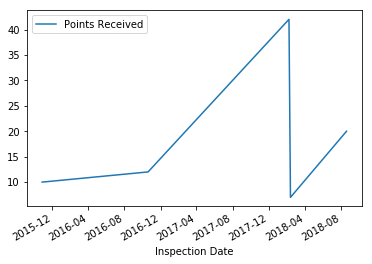

In [39]:
foursquare_report("3fd66200f964a52000e71ee3")

In [40]:
## I might also want to compare the health inspection performance of a given restaurant to its competitors.
## For instance, I could compare it with nearby restaurants the same cuisine.
## To keep things simple. I'll return the five closest restaurants of the same cuisine type along with their addresses and points per inspection 
## I will use Euclidean distance to form a KD-tree that will allow rapid lookup of the five nearest neighbors

from sklearn.neighbors import KDTree

def cuisine_compare(ID):
    rest_df=fsq_health[fsq_health['fsq_id_x'] == ID]
    cuisine=rest_df.cuisine_description.unique()[0]
    lat=rest_df.lat.unique()[0]
    long=rest_df.long.unique()[0]
    cuisine_df=fsq_health[fsq_health.cuisine_description == cuisine]
    lat_group = cuisine_df.groupby(['name_address','lat'])
    long_group = cuisine_df.groupby(['name_address','long'])
    lats=lat_group.apply(lambda x: x['name_address'].unique()[0])
    longs=long_group.apply(lambda x: x['name_address'].unique()[0])
    latlong_zip=list(zip(lats.reset_index()['lat'],longs.reset_index()['long']))
    kdt=KDTree(latlong_zip,leaf_size=30,metric="euclidean")
    nb=kdt.query(np.asarray([lat,long]).reshape(1,-1),k=6,return_distance=False)
    
    ##subfunction to get names and points per inspection for the five closest neighbors
    def get_ppi(name):
        rest_df=fsq_health[fsq_health['name_address'] == name]
        group = rest_df.groupby(['inspection_datetime'])
        score = group.apply(lambda x: np.nansum(np.asarray(x['score'].unique())))
        ppi=score.sum() / sum(~np.isnan(np.asarray(score)))
        return(print(name, ": ",ppi))
    
    
    ##return names and points per inspection for the five closest neighbors
    get_ppi(lats[nb[0][1]])
    get_ppi(lats[nb[0][2]])
    get_ppi(lats[nb[0][3]])
    get_ppi(lats[nb[0][4]])
    get_ppi(lats[nb[0][5]])

In [41]:
## Using our test case from above, here are the five closest restuarants of cuisine type "American", their addresses, and their average points per health inspection
## Lower numbers are better! For the purposes of an app we could rescale this into something more intuitive; e.g., a 1-10 rating

cuisine_compare("3fd66200f964a52000e71ee3")

FLIP 'N TOSS 82 CHRISTOPHER ST :  10.0
MARIES CRISIS CAFE 59 GROVE STREET :  13.0
DUE WEST 189 W 10TH ST :  0.0
FAIRFAX 234 W 4TH ST :  15.25
WHILE WE WERE YOUNG 183 W 10TH ST :  10.0


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexes/multi.py:848: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_value(s, k)


In [42]:
## We can see that we have better choices, in terms of points per health inspection, for nearby "American" style cuisine. 
## This comparison could easily be appended to the output of the foursquare_report function.

# Assessing the relationship between health inspection performance and Foursquare user rating

In [43]:
## This data might also be useful for restaurants. 
## For example, Restaurants might be interested in how health inspection performance relates to user ratings on Foursquare ("do health inspections really matter?")

## Getting the rating of a particular Foursquare venue is a premium call, limited to 500 a day on the sandbox account. 
## Using Foursquare API calls from my local machine, I've collected ~2500 venue detail records so far from restaurants from our list of ~13,000 restaurants with a single foursquare ID result.
## I then extracted just the venue rating from these json results.
## Let's read these details from memory



In [44]:

body = client_6b7df39f88b14619910d4a35856d04d3.get_object(Bucket='courseracapstone-donotdelete-pr-rvx0gr3mhts3vq',Key='ids_with_rating.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_5 = pd.read_csv(body,sep='\t',header=None, names=["fsq_id_x","rating"])

ratings=df_data_5
ratings.head()



,fsq_id_x,rating
0,3fd66200f964a52000e71ee3,8.8
1,3fd66200f964a52000f11ee3,7.6
2,3fd66200f964a52001e81ee3,5.6
3,3fd66200f964a52001e91ee3,6.8
4,3fd66200f964a52002eb1ee3,8.7


In [45]:
## Remove rating for restaurants with no health inspection data
## These arose when I did some additional data cleaning after already beginning my premium API calls.
ratings_filt=ratings[ratings['fsq_id_x'].isin(fsq_health['fsq_id_x'].unique())]

In [46]:
## Let's retrieve the points per inspection for each restaurant with a Foursquare rating and health inspection data

def get_ppi(ID):
    rest_df = fsq_health[fsq_health['fsq_id_x'] == ID]
    group = rest_df.groupby(['inspection_datetime'])
    score = group.apply(lambda x: np.nansum(np.asarray(x['score'].unique())))
    ppi= score.sum() / sum(~np.isnan(np.asarray(score)))
    return(ppi)

ratings_filt['ppi']=ratings_filt['fsq_id_x'].apply(get_ppi)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


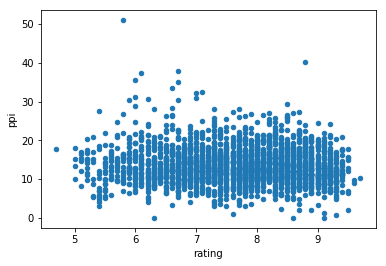

In [47]:
ratings_filt.plot(x='rating',y='ppi',kind="scatter")

In [48]:
ratings_filt['rating'].corr(ratings_filt['ppi'])

-0.064334660643287064

In [49]:
### So it does appear there is negative relationship between points per inspection and average rating from foursquare users. 
### But it's quite a weak relationship.
### It does seem that restaurants with >30 points per inspection do tend to be poorly performing. The outlier at ~ppi=40,rating=9 seems to warrant further inspection.
### I took a look and it seems like a restaurant that very recently had a bad inspection and was closed. It would be interesting to see if this eventually affects the restaurants rating
### There is another observation I noticed when using a log-transformation on the points per inspection:

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


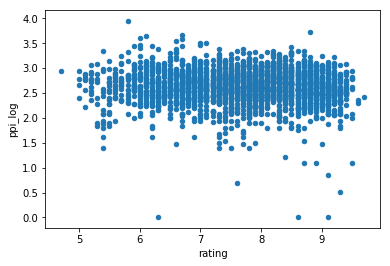

In [50]:
ratings_filt['ppi_log']=ratings_filt['ppi'].apply(lambda x: np.log(x+1))
ratings_filt.plot(x='rating',y='ppi_log',kind="scatter")


In [51]:
### What we can more easily see here is that "squeaky-clean" restaurants (e.g., log(ppi) of ~1.25 or less) do seem to have higher ratings.
### It would be interesting to see if this observation holds when more ratings are added to the dataset. As of right now, we only have a handful of such restaurants in the dataset
### Given more time, I would also want to look at outliers in terms of rating or points per inspection, and potentially remove restaurants without enough user ratings or inspections to have a reliable estimate of performance.
### It might turn out that health inspections tend to matter for user ratings, but only at the extremes (e.g., very good or bad inspection results)
### I could use a polynomial regression to try and capture this effect.
### I might also bin restaurants into ppi "classes", and use e.g., ANOVA to find the classes that tend to impact user rating the most

### Furthermore, we might expect to see a stronger relationship with the measure of inspection performance readily viewable by the public - the inspection grade.
### I could also ANOVA to investigate the effect of inspection grade (most recent or most common) on Foursquare user rating. 

In [52]:
## Ok, lets try looking at health grades vs foursquare user ratings
## Get modal grade



# Predicting restaurant closure: what violations are most important?

In [53]:
### Another way restaurants might use this data is find health code violations are most strongly associated with closure of the restaurant by DOHMH.
### Closure certainly doesn't look good, especially if people start paying more attention to this data!
### So which health code violations are most important to avoid if we don't want our restaurant closed?
### I've taken two approaches to address this question. Both rely on logistic regression.

In [54]:
### First, I use recursive feature elimination to retain only the health code violations with the strongest relationship (in a logistic regression) to restaurant closure. 
##To begin, we need to group by unique inspection. This line will also conveniently convert the violation code column into a set of one-hot encoded variables
all_inspections=pd.crosstab(fsq_health.Unique_Inspection,fsq_health.violation_code)


In [55]:
##Now we retrieve the action for each inspection
group = fsq_health.groupby(['Unique_Inspection'])
action = group.apply(lambda x: x['action'].unique())
all_inspections['action'] = group.apply(lambda x: x['action'].unique()[0])

In [56]:
##I want to parse the actions to find those with "Closed" or "closed" and then code these as 1s and all other actions as 0s
all_inspections['action_lower']=all_inspections['action'].str.lower()
all_inspections['closed']=all_inspections['action_lower'].str.contains("closed")
all_inspections['closed']=all_inspections['closed'].astype(int)


In [57]:
all_inspections.columns

Index(['02A', '02B', '02C', '02D', '02E', '02F', '02G', '02H', '02I', '02J',
       '03A', '03B', '03C', '03D', '03E', '03F', '03G', '04A', '04B', '04C',
       '04D', '04E', '04F', '04G', '04H', '04J', '04K', '04L', '04M', '04N',
       '04O', '05A', '05B', '05C', '05D', '05E', '05F', '05H', '06A', '06B',
       '06C', '06D', '06E', '06F', '06G', '06H', '07A', '08A', '08B', '08C',
       '09A', '09B', '09C', '10A', '10B', '10C', '10D', '10E', '10F', '10G',
       '10H', '10I', '10J', '17A', '18B', '18C', '18D', '18F', '18G', '20A',
       '20B', '20D', '20E', '20F', '22A', '22B', '22C', '22E', '22F', '22G',
       'action', 'action_lower', 'closed'],
      dtype='object', name='violation_code')

In [58]:
## Now we can run Recursive Feature Elimination on the health code categories
## Here I'm retaining the 10 most important features and returning their names
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
model = LogisticRegression()
X=all_inspections.iloc[:,0:79]
y=all_inspections['closed']
rfe = RFE(model, 10)
fit = rfe.fit(X, y)
X.columns[fit.support_]


Index(['03E', '04F', '05A', '05C', '05E', '05F', '05H', '08A', '18C', '18D'], dtype='object', name='violation_code')

In [59]:
## Let's look up the descriptions of these violations
## First, make a dictionary of violation codes and descriptions
group = fsq_health.groupby(['violation_code'])
description = group.apply(lambda x: x['violation_description'].unique())

In [60]:
## Now return the description for each violation
description[X.columns[fit.support_]]

violation_code
03E    [Potable water supply inadequate. Water or ice...
04F    [Food, food preparation area, food storage are...
05A     [Sewage disposal system improper or unapproved.]
05C    [Food contact surface improperly constructed o...
05E    [Toilet facility not provided for employees or...
05F    [Insufficient or no refrigerated or hot holdin...
05H    [No facilities available to wash, rinse and sa...
08A    [Facility not vermin proof. Harborage or condi...
18C    [Notice of the Department of Board of Health m...
18D    [Failure to comply with an Order of the Board ...
dtype: object

In [61]:
## These sound important, and indeed many of them are among the infractions with the highest average penalty (see https://www1.nyc.gov/assets/doh/downloads/pdf/rii/self-inspection-worksheet.pdf)
## The top three are "Public Health Hazards", which must be corrected at the time of inspection to avoid closure. 
## The next few violations are in the category of "Pre-permit Serious Violations", which must be corrected before a permit is issued (5C,5E,5F)
## Then there is a commonly handed out violation regarding pest risk (08A).
## The last two infractions are the most interesting to me (18C, 18D)
## If you don't want your restaurant closed, you should display your Health Inspection notice and follow the instructions of your inspector!
## The most interesting thing about these last two infractions is that they aren't actually worth any points! ('unscored violations')

In [62]:
### My second approach relies on principal components analysis (PCA).
### Running a logistic regression using all 90+ violation codes as predictor variables might give problematic coefficients due to multicolinearity of our predictors.
### Principal components are linear combinations of features that are uncorrelated with one another.
### Using principal components, I can run logistic regression without worrying about multicolinearity between the predictors. 
### I can then identify the principal component(s) with the strongest predictive power in the logistic regression model.
### Finally, I can identify the individual features that are themselves most strongly correlated with these components. 
### Similar to recursive feature elimination, we end up with a reduced set of "important" features

In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X)
print(pca.explained_variance_)

[ 0.37935717  0.22258961  0.16686567  0.15978865  0.14759357  0.14486888
  0.14044597  0.1306356   0.07197456  0.06255804]


In [64]:
my_ponents=pd.DataFrame(pca.components_,columns=all_inspections.iloc[:,0:79].columns,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10'])

In [65]:
m=LogisticRegression()
X=pca.fit_transform(X)
y=all_inspections['closed']

m.fit(X,y)
m.coef_


array([[ 1.8798581 ,  0.57611752, -0.02922662,  0.20544625,  0.62934725,
         0.78651768, -0.19560122,  0.3857764 ,  1.17280922,  1.05030813]])

In [66]:
np.exp(m.coef_)

array([[ 6.55257499,  1.77911761,  0.97119634,  1.22807297,  1.87638538,
         2.19573683,  0.8223401 ,  1.47075578,  3.23105667,  2.85853179]])

In [67]:
#PC1, which explains 38% of the variance, is the most important predictor variable
#Let's display infractions (features) that are strongly correlated with PC1
my_ponents.transpose()['PC-1'].sort_values(ascending=False)[0:5]


violation_code
08A    0.687383
04L    0.507501
04N    0.271477
04M    0.099584
04K    0.029928
Name: PC-1, dtype: float64

In [68]:
## Lets look at the top three variables in this case (correlations > 0.26)
description[my_ponents.transpose()['PC-1'].sort_values(ascending=False)[0:3].index].values

array([ array([ 'Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.'], dtype=object),
       array([ "Evidence of mice or live mice present in facility's food and/or non-food areas."], dtype=object),
       array([ 'Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility\x1as food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.'], dtype=object)], dtype=object)

In [69]:
# Interesting. None of these are Public Health Hazards, which can result in immediate closure if not fixed at the time of inspection.
# So a major "axis of variation" of health inspection results is correlated with something like "risk for or presence of pests"
# Moreover, this axis is informative for whether or not the health inspection resulted in a closure. 
# How about the other PCs with coefficients >1?

In [70]:
print(my_ponents.transpose()['PC-9'].sort_values(ascending=False)[0:5])
description[my_ponents.transpose()['PC-9'].sort_values(ascending=False)[0:2].index].values

violation_code
04M    0.813835
08A    0.251304
04K    0.063451
08C    0.040628
06F    0.023082
Name: PC-9, dtype: float64


array([ array(["Live roaches present in facility's food and/or non-food areas."], dtype=object),
       array([ 'Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.'], dtype=object)], dtype=object)

In [71]:
#More stuff about pests.

In [72]:
print(my_ponents.transpose()['PC-10'].sort_values(ascending=False)[0:5])
description[my_ponents.transpose()['PC-10'].sort_values(ascending=False)[0:2].index].values


violation_code
04H    0.991678
06E    0.079934
04M    0.058586
04L    0.036950
10F    0.027819
Name: PC-10, dtype: float64


array([ array([ 'Raw, cooked or prepared food is adulterated, contaminated, cross-contaminated, or not discarded in accordance with HACCP plan.'], dtype=object),
       array([ 'Sanitized equipment or utensil, including in-use food dispensing utensil, improperly used or stored.'], dtype=object)], dtype=object)

In [73]:
#"4H: Raw, cooked or prepared food is adulterated, contaminated, cross-contaminated or not discarded in accordance with HACCP plan"
# This is a public health hazard, which can result in closure of a restaurant if not corrected at the time of inspection. 
# Perhaps this PHH is particularly common, or difficult to fix at the time of inspection.

# Visualizing health inspection frequency and performance to help spatially prioritize future inspection efforts

In [74]:
## Finally, this data might be useful to the DOHMH itself.
## For example, by linking to Foursquare location data, we can look for spatial patterns in inspection results.
## By calculating the average points per inspection in an area, we can identify areas of the city where restaurants are not performing well on their health inspections.
## The DOHMH intentionally revists poorly-performing restaurants more often. So poorly-performing areas should be getting more visits.
## With this in mind, we can also find areas that are poorly performing relative to the rate of inspection in that area. 
## These areas could make good targets for more frequent visits from the DOHMH. 
## Of course, this idea would only work if the DOHMH wants to prioritize regions (rather than specific restaurants)
## I'm using a hexbin plot here, but the data could be split up into e.g., neighborhoods or zones that the DOHMH is interested in distributing their resources among. 

In [75]:
def get_ppi(name):
    rest_df = fsq_health[fsq_health['name_address'] == name]
    group = rest_df.groupby(['inspection_datetime'])
    score = group.apply(lambda x: np.nansum(np.asarray(x['score'].unique())))
    ppi=score.sum() / sum(~np.isnan(np.asarray(score)))
    return(ppi)

def get_total_inspections(name):
    rest_df=fsq_health[fsq_health['name_address'] == name]
    group = rest_df.groupby(['inspection_datetime'])
    score = group.apply(lambda x: np.nansum(np.asarray(x['score'].unique())))
    return(sum(~np.isnan(np.asarray(score))))

allnames = fsq_health.groupby(['name_address']).count().index.to_series()
scores_total = allnames.map(get_ppi)
inspections_total = allnames.map(get_total_inspections)
average = scores_total / inspections_total
group = fsq_health.groupby(['name_address'])
latitudes=group.apply(lambda x: x['lat'].unique()[0])
longitudes=group.apply(lambda x: x['long'].unique()[0])
scores_ll=pd.DataFrame(list(zip(average.index,average,inspections_total,latitudes,longitudes)),columns=['Name','Average','Total','Lat','Long'])
scores_ll.head()

,Name,Average,Total,Lat,Long
0,#1 Chinese Restaurant 825 W 181ST ST,4.320000,5,40.850859,-73.938342
1,#1 SABOR LATINO RESTAURANT 4120 WHITE PLAINS ROAD,3.591837,7,40.891539,-73.858547
2,'CESCA 166 W 75TH ST,12.000000,1,40.780533,-73.980094
3,'WICHCRAFT 1407 BROADWAY,24.000000,1,40.753065,-73.987454
4,(LEWIS DRUG STORE) LOCANDA VINI E OLII 129 GAT...,2.000000,3,40.684852,-73.962929


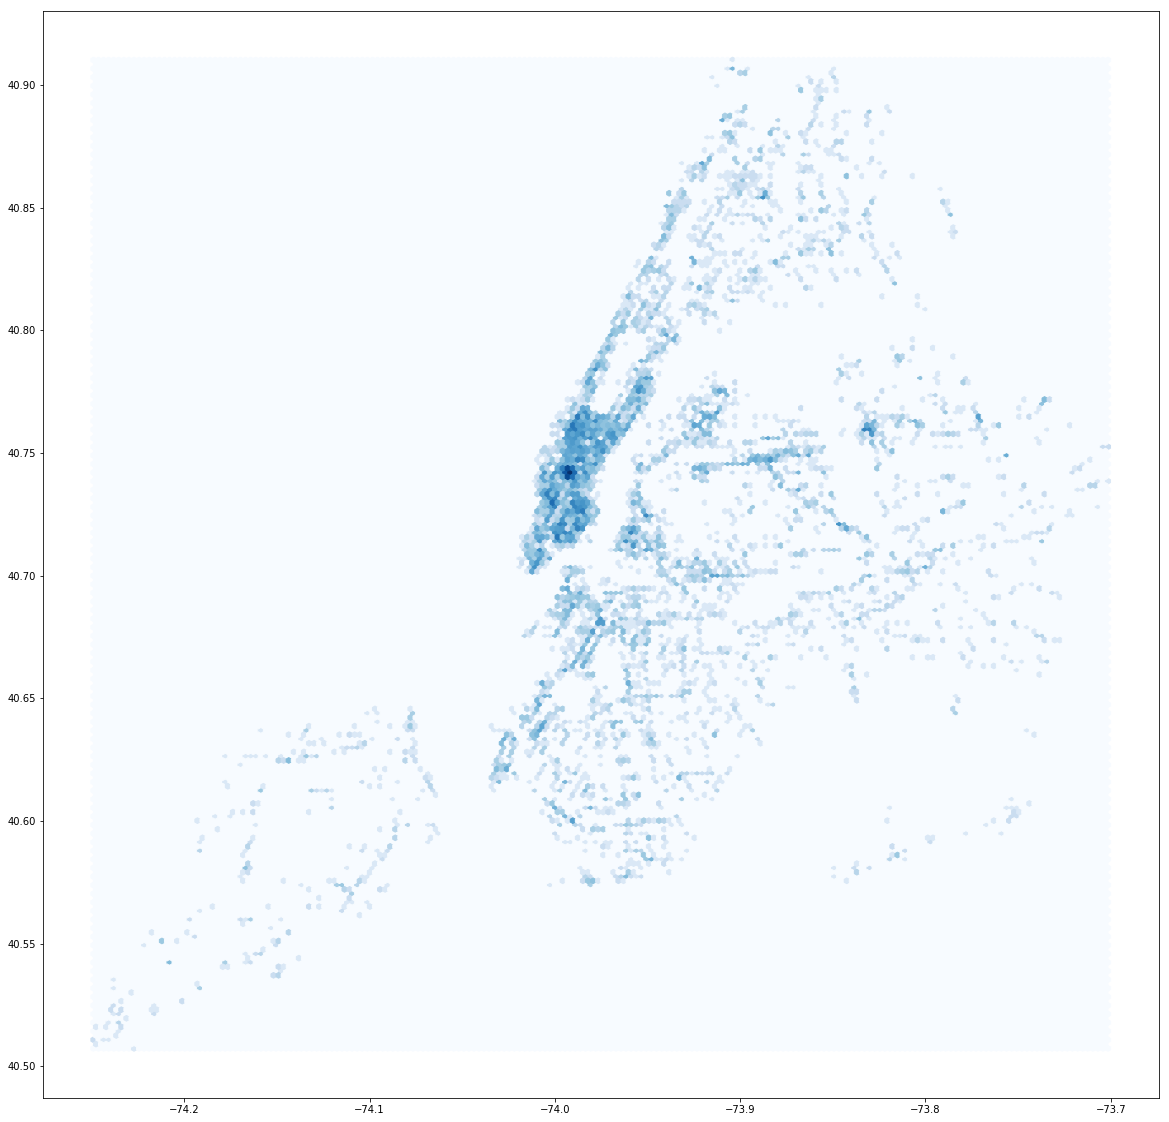

In [76]:
##This first plot should just give us density of restaurants in the NYC area
plt.figure(figsize=(20,20))
hexplot=plt.hexbin(scores_ll['Long'], scores_ll['Lat'], gridsize=200, cmap='Blues',bins="log")

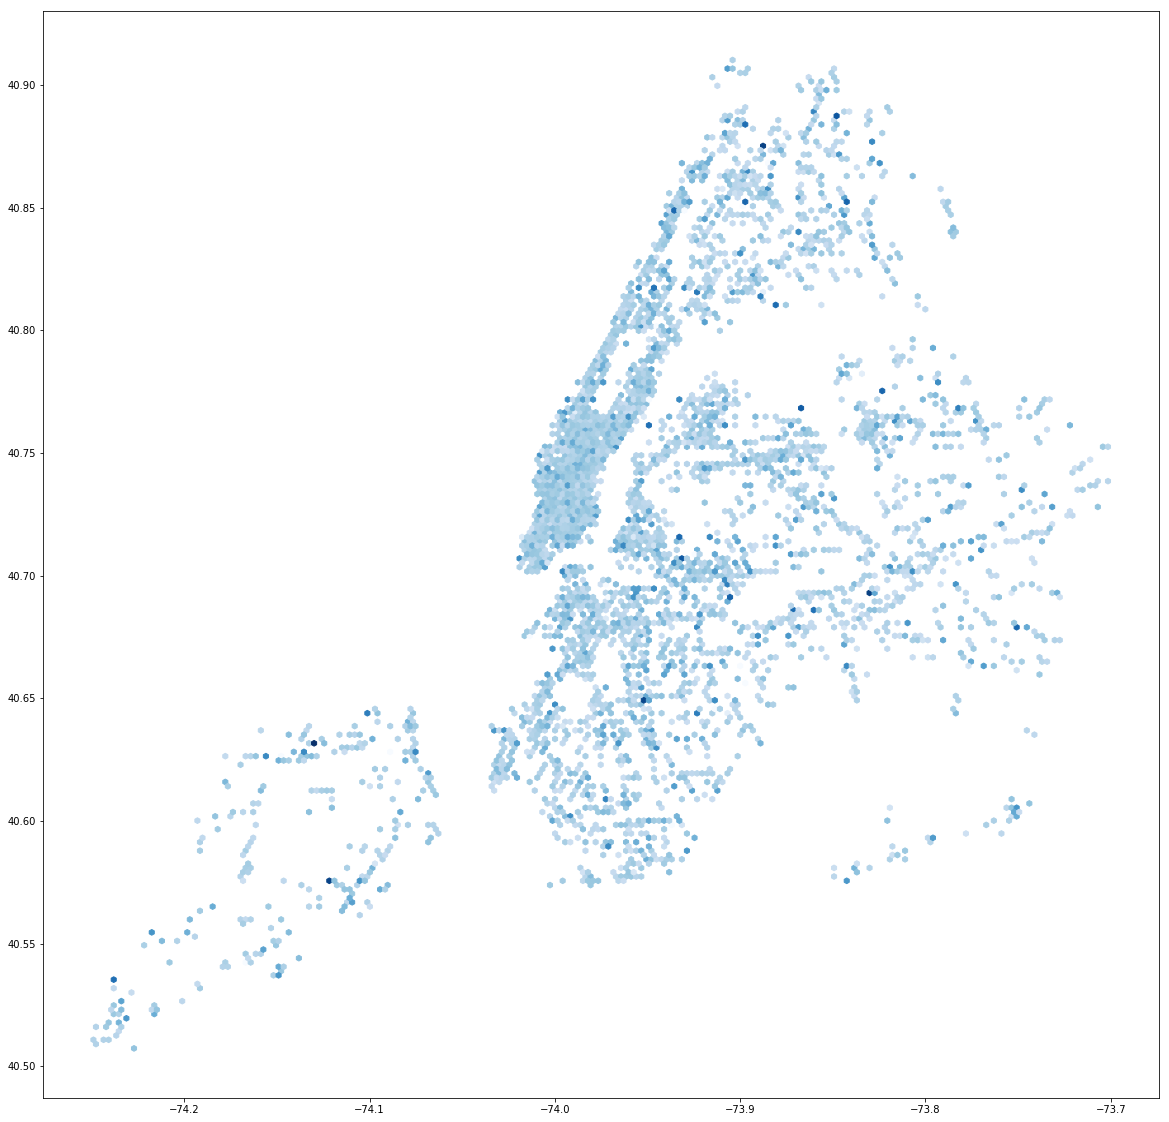

In [77]:
## This plot will give us average of the average points per inspection for each restaurant in the bin.
plt.figure(figsize=(20,20))
hexplot=plt.hexbin(scores_ll['Long'], scores_ll['Lat'], gridsize=200, cmap='Blues',C=scores_ll['Average'],bins="log")

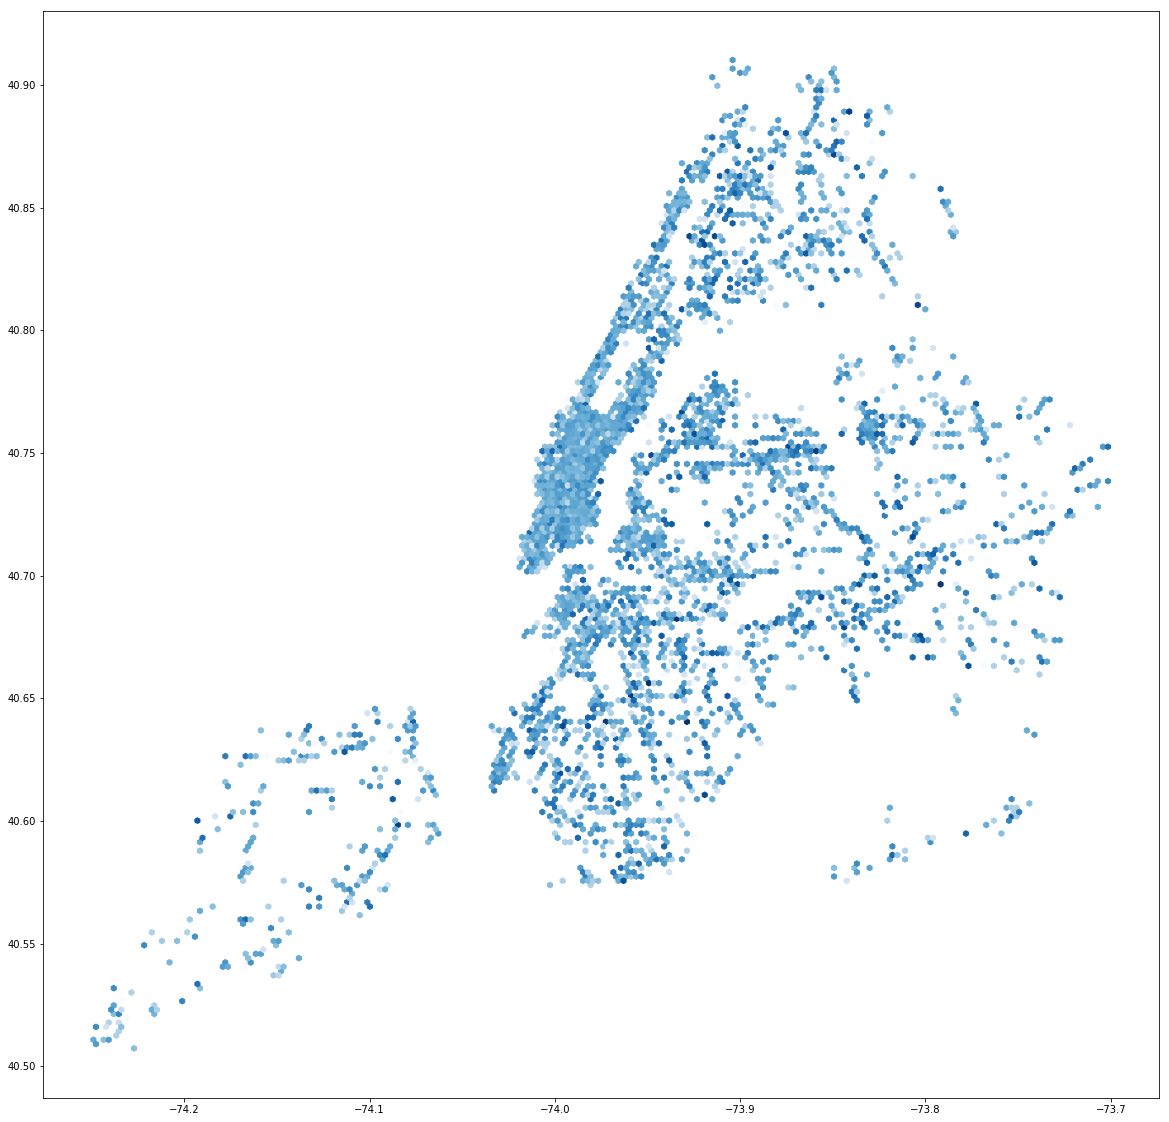

In [103]:
## This plot will give us average total number inspections for each restaurant in the bin.
## 
plt.figure(figsize=(20,20))
hexplot=plt.hexbin(scores_ll['Long'], scores_ll['Lat'], gridsize=200, cmap='Blues',C=scores_ll['Total'],bins="log")

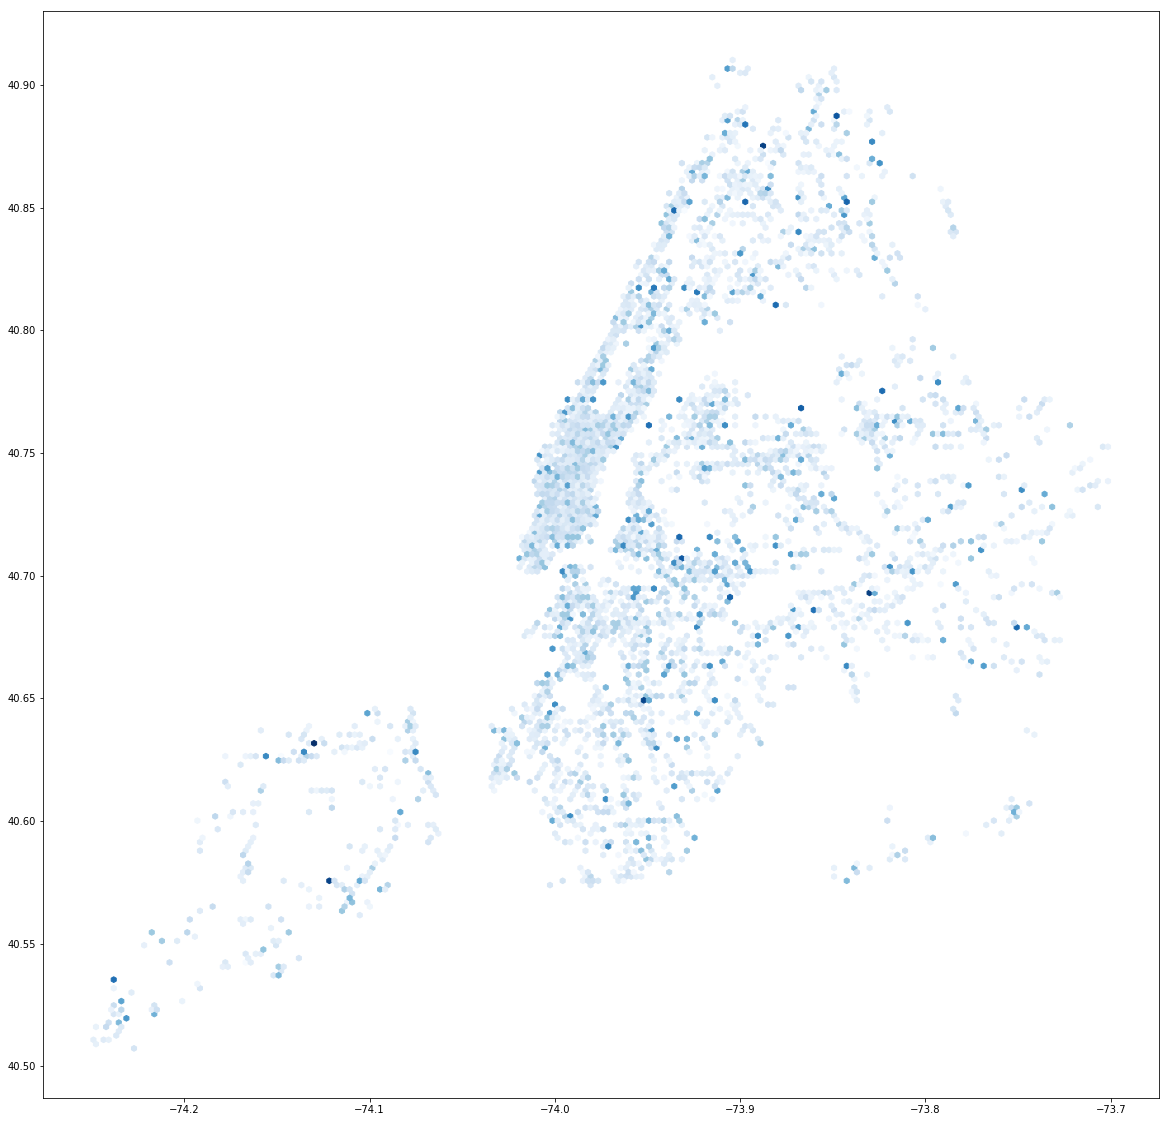

In [79]:
## Because the DOHMH intentionally revisits poorly-performing restaurants more often, we might expect that restaurants with more visits also have higher averages.
## We can get an idea of how well restaurants are scoring given the number of inspections by diving the average score by the number of inspections.
## This "visit-corrected" average should highlight areas where restaurants are scoring poorly and/or have not been inspected very many times relative to their score
plt.figure(figsize=(20,20))
hexplot=plt.hexbin(scores_ll['Long'], scores_ll['Lat'], gridsize=200, cmap='Blues',C=(scores_ll['Average']/scores_ll['Total']),bins="log")

In [80]:
## The bins with the highest values above might warrant more attention from the DOHMH

In [81]:
## It has to be possible to rank the bins and get the restaurants located within each bin...

In [83]:
paths = hexplot.get_paths()
offsets = hexplot.get_offsets()
arr = hexplot.get_array()

In [84]:
arr[-10:]

array([ 0.15268462,  0.14121744,  0.06051649,  0.07277974,  0.55930801,
        0.05537833,  0.18571097,  0.31499576,  0.06231752,  0.18601231])

In [85]:
path_verts = paths[0].vertices
path_codes = paths[0].codes

In [89]:
import matplotlib
def get_rests(pts):
    myverts = path_verts + pts
    res=matplotlib.path.Path(myverts,path_codes).contains_points(np.array([scores_ll['Long'],scores_ll['Lat']]).transpose())
    return(scores_ll[res])

In [90]:
np.argsort(arr)[-9:]

array([2953, 3160,  980, 3260, 2537, 1856, 1335, 1572, 1852])

In [102]:
get_rests(offsets[3160])

,Name,Average,Total,Lat,Long
5758,LAGUARDIA PLAZA HOTEL/PAVILLION GRILL 10404 DI...,3.875,4,40.767418,-73.866987
7716,NEW YORK LAGUARDIA AIRPORT MARRIOTT 10205 DITM...,51.000,1,40.768944,-73.867635


### So it looks like a lot of the highest-priority bins are driven by either singletons or outliers.

### Nice to know how to retrieve the members of each bin, though.

### How I'd proceed if I wanted to stick with the hexplot: I could only consider bins with at least a certain number of restaurants in them. I could increase the size of the hexagon bins. 

### However, a better idea would be to use regions like neighborhoods or boroughs, that the DOHMH is specifically interested in prioritizing. 

### Of course, I could also prioritize individual restaurants, rather than regions. A spatial analysis only makes sense if the DOHMH wants spatial priorities. 